# OOD Detection for Customer Intent Classification


## Setup

In [3]:
# setup for google colab

from google.colab import drive
drive.mount("/content/drive")

import os 
os.chdir("/content/drive/MyDrive/NLP/OOD-Detection-Intent-Classification")
print(os.getcwd())

!pip install -r requirements.txt

KeyboardInterrupt: ignored

### Import

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import pandas as pd 
import numpy as np 
from tqdm import tqdm

from typing import List, Dict
from enum import Enum

from rich import print

from itertools import chain

import matplotlib.pyplot as plt 
from matplotlib.axes import Axes
import seaborn as sns

import pickle as pkl 
import json

In [ ]:

from sklearn.metrics import (
    roc_curve, 
    precision_recall_curve, 
    auc
) 

In [ ]:
from transformers import AutoConfig

import torch 
from torch import Tensor

In [ ]:
from Todd import (
    ScorerType, 
    MahalanobisScorer, 
    CosineProjectionScorer, 
    DataDepthScorer, 
)

In [8]:
from toddbenchmark.classification_datasets import (
    prep_model, 
    load_b77, 
)
from toddbenchmark.classification_datasets_configs import (
    DATASETS_CONFIGS,
    load_requested_dataset,
)

from toddbenchmark.utils_classification import (
    prepare_detectors,
    evaluate_dataloader,
)

### Helper Functions

In [9]:
SCORERS = [
    "MahalanobisScorerLast", 
    "MahalanobisScorerAvg", 
    "CosineProjectionScorerAvg", 
    "msp", 
    "energy"
]

HD_SCORERS = [
    "MahalanobisScorer", 
    "MahalanobisScorer", 
    "CosineProjectionScorer",
]

COLORS_SCORERS = {
    scorer: col 
    for scorer, col in zip(SCORERS, sns.color_palette(n_colors=len(SCORERS))) 
}


DS = [
    "in_train",
    "in_test",
    "in_clinc", 
    "out_atis", 
    "out_bitext", 
    "out_clinc"
]

COLORS_DS = {
    ds: col 
    for ds, col in zip(DS, sns.color_palette(n_colors=len(DS))) 
}

class Model(Enum): 
    BERT = "philschmid/BERT-Banking77"
    DistilBERT = "philschmid/DistilBERT-Banking77"

class HiddenLayers(Enum):
    BERT = 13 
    DistilBERT = 6

class LayerSelection(Enum): 
    LAST = [-1]

    ALL_BERT = [l for l in range(HiddenLayers.BERT.value)]
    ALL_DistilBERT = [l for l in range(HiddenLayers.DistilBERT.value)]

    ENCODER_BERT = [l for l in range(1, HiddenLayers.BERT.value)]
    ENCODER_DistilBERT = [l for l in range(1, HiddenLayers.DistilBERT.value)]

def average_scorer_per_layer(records: Dict, scorer_name: str) -> np.ndarray:
    """Description. Average scorer values across multiple layers."""

    if scorer_name not in HD_SCORERS:
        raise ValueError(f"scorer_name must be in {HD_SCORERS}")

    values_per_layer = [
        values 
        for key, values in records.items()
        if scorer_name in key and "-1" not in key
    ]

    return np.mean(values_per_layer, axis=0)

def get_scorer_per_layer(records: Dict, scorer_name: str, layer: int) -> List: 
    """Description. Return scorer values for one layer."""

    if scorer_name not in HD_SCORERS:
        raise ValueError(f"scorer_name must be in {HD_SCORERS}")

    values = [
        values 
        for key, values in records.items()
        if scorer_name in key and str(layer) in key
    ]

    return values[0]

def plot_scorer_distrib(
    scorer: str, 
    records: List, 
    ds_names: List, 
    ax: Axes, 
    density: bool
  ): 
    """Description. Return histogram/density plot for scorer values.
    
    Details: if scorer is CosineProjectionScorer, only test in-ds and out-ds are plotted."""

    for ds in ds_names: 
        if ds not in DS: 
          raise ValueError(f"{ds} not in {DS}.")

    tmp = pd.DataFrame\
        .from_dict(records, orient="index")\
        .transpose()[ds_names]
    title = scorer

    if "CosineProjectionScorer" in scorer and "in_train" in tmp.columns:
        tmp = tmp.drop(labels=["in_train"], axis=1)
        title += "\nWithout training IN-DS (reference)"

    args = {
        "bins": 100, 
        "palette": [color for ds, color in COLORS_DS.items() if ds in tmp.columns]
    }   

    if density: 
        args["stat"] = "density"
        args["kde"] = True

    sns.histplot(data=tmp, ax=ax, **args)

    ax.set_title(title) 

def load_records(model: Model, dataset: str) -> Dict:
    """Description. Load records from backup/folder.""" 

    file_path = f"./backup/{model.name}_records_{dataset}.pkl"
    with open(file_path, "rb") as file: 
        records = pkl.load(file)

    return records

def save_records(records: Dict, model: Model, dataset: str): 

    file_path = f"./backup/{model.name}_records_{dataset}.pkl"
    with open(file_path, "wb") as file: 
        pkl.dump(records, file)
        print(f"File successfully saved at {file_path}.")

### Load config, model and tokenizer

In [10]:
config = AutoConfig.from_pretrained(Model.BERT.value) 
config

BertConfig {
  "_name_or_path": "philschmid/BERT-Banking77",
  "_num_labels": 77,
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "Refund_not_showing_up",
    "1": "activate_my_card",
    "2": "age_limit",
    "3": "apple_pay_or_google_pay",
    "4": "atm_support",
    "5": "automatic_top_up",
    "6": "balance_not_updated_after_bank_transfer",
    "7": "balance_not_updated_after_cheque_or_cash_deposit",
    "8": "beneficiary_not_allowed",
    "9": "cancel_transfer",
    "10": "card_about_to_expire",
    "11": "card_acceptance",
    "12": "card_arrival",
    "13": "card_delivery_estimate",
    "14": "card_linking",
    "15": "card_not_working",
    "16": "card_payment_fee_charged",
    "17": "card_payment_not_recognised",
    "18": "card_payment_wrong_exchange_rate",
   

In [11]:
LABEL_MAPPING = config.id2label
LABEL_MAPPING

{0: 'Refund_not_showing_up',
 1: 'activate_my_card',
 2: 'age_limit',
 3: 'apple_pay_or_google_pay',
 4: 'atm_support',
 5: 'automatic_top_up',
 6: 'balance_not_updated_after_bank_transfer',
 7: 'balance_not_updated_after_cheque_or_cash_deposit',
 8: 'beneficiary_not_allowed',
 9: 'cancel_transfer',
 10: 'card_about_to_expire',
 11: 'card_acceptance',
 12: 'card_arrival',
 13: 'card_delivery_estimate',
 14: 'card_linking',
 15: 'card_not_working',
 16: 'card_payment_fee_charged',
 17: 'card_payment_not_recognised',
 18: 'card_payment_wrong_exchange_rate',
 19: 'card_swallowed',
 20: 'cash_withdrawal_charge',
 21: 'cash_withdrawal_not_recognised',
 22: 'change_pin',
 23: 'compromised_card',
 24: 'contactless_not_working',
 25: 'country_support',
 26: 'declined_card_payment',
 27: 'declined_cash_withdrawal',
 28: 'declined_transfer',
 29: 'direct_debit_payment_not_recognised',
 30: 'disposable_card_limits',
 31: 'edit_personal_details',
 32: 'exchange_charge',
 33: 'exchange_rate',
 34: 

In [12]:
model, tokenizer = prep_model(Model.BERT.value, config={"label": config._num_labels})

In [13]:
model 

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

## Datasets

Inspired by this [article](https://arxiv.org/abs/2104.08812), an instance $(\mathrm{x}, y)$ to be OOD if $y \notin \mathcal{Y}_{\text{train}}$. In this context, all instances in the training and test sets derived from `banking77` are labelled `OOD=0`. The entries from CLINC150 whose labels are in the b77 set of labels are also considered `OOD=0`. In the opposite, the instances in `ATIS` and `Bitext`, as well as those in CLINC150 with labels not in the b77 set of labels,   are labelled `OOD=1`.

Then, different OOD scoring functions $f(\mathrm{x}): \mathcal{X} \to \mathbb{R}$ are applied to all the instances. The functions are supposed to return a low (high) score for an instance such that $y\in\mathcal{Y}_{\text{train}}$ ($y\notin\mathcal{Y}_{\text{train}}$).

### Load IN-DS dataset

#### `banking77`

In [14]:
config_args_in = {
    "tokenizer": tokenizer, 
    "train_size": 3000, 
    "validation_size": 0, 
    "test_size": 3000, 
    "ood_label": 0
}

In [15]:
train_loader_b77, _, test_loader_b77 = load_requested_dataset(config_name="b77", **config_args_in)

Generating train split:   0%|          | 0/10003 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3080 [00:00<?, ? examples/s]

Dataset banking77 downloaded and prepared to /root/.cache/huggingface/datasets/banking77/default/1.1.0/ff44c4421d7e70aa810b0fa79d36908a38b87aff8125d002cd44f7fcd31f493c. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Aligning the labels:   0%|          | 0/10003 [00:00<?, ? examples/s]

Aligning the labels:   0%|          | 0/3080 [00:00<?, ? examples/s]

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [16]:
for batch in train_loader_b77: 
    break 

batch

{'text': ['I am still waiting on my card?',
  "What can I do if my card still hasn't arrived after 2 weeks?",
  'I have been waiting over a week. Is the card still coming?',
  'Can I track my card while it is in the process of delivery?',
  'How do I know if I will get my card, or if it is lost?',
  'When did you send me my new card?',
  'Do you have info about the card on delivery?',
  'What do I do if I still have not received my new card?',
  'Does the package with my card have tracking?',
  "I ordered my card but it still isn't here",
  'Why has my new card still not come?',
  "I still haven't received my card after two weeks, is it lost?",
  'Can you track my card for me?',
  'Is there a way to track the delivery of my card?',
  "It's been a week since I ordered my card and it's not here. Please help?",
  'Will I be able to track the card that was sent to me?'],
 'labels': tensor([12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12]),
 'ood': tensor([0, 0, 0, 0, 0, 0, 0

In [137]:
assert sum(batch["labels"].shape[0] for batch in train_loader_b77) == config_args_in["train_size"]
assert sum(batch["labels"].shape[0] for batch in test_loader_b77) == config_args_in["test_size"]

#### `CLINC150`

Since the intent classifier used in the study has only been trained on instance from `banking77`, the IN-DS examples from `CLINC150` are test samples. 

In [17]:
config_args_in_clinc = {
    "tokenizer": tokenizer, 
    "train_size": 0, 
    "validation_size": 0, 
    "test_size": 750, 
    "ood_label": 0, 
    "data_path": "./datasets/"
}

_, _, test_loader_clinc_in = load_requested_dataset(config_name="clinc150_in", **config_args_in_clinc)

In [139]:
for batch in test_loader_clinc_in: 
    break 

batch 

{'text': ["what's the time of arrival on my new credit card",
  'tell me the duration it takes to get a new cc',
  'is it a short time before i receive my new credit card',
  'how long before my updated cc takes to arrive',
  'how long does it take a new card to arrive in the mail to me',
  'what is the length of time it takes a new card to get mailed to me',
  'about how long does it usually take a new card to get mailed to me',
  'how much time does it take a new card to get mailed to me',
  'how soon does it take a card new card to get mailed to me',
  'after losing a credit card, how long does it take to get a new one',
  'if i lose my credit card, will i get a replacement immediately',
  'what is the time frame for receiving a new credit card if my original one gets lost',
  'will i have to wait a long time to receive my new credit card after i lost my old one',
  'how long should i expect to wait for my replacement credit card',
  'will my new credit card be here this week',
  'h

### Load OUT-DS dataset

In [18]:
config_args_out = {
    "tokenizer": tokenizer, 
    "train_size": 0, 
    "validation_size": 0, 
    "test_size": 3000, 
    "ood_label": 1, 
    "data_path": "./datasets/"
}

In [19]:
_, _, test_loader_atis = load_requested_dataset(config_name="atis", **config_args_out)
_, _, test_loader_bitext = load_requested_dataset(config_name="bitext", **config_args_out)
_, _, test_loader_clinc_out = load_requested_dataset(config_name="clinc150_out", **config_args_out)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [142]:
for batch in test_loader_atis: 
    break

batch

{'text': ['i want to fly from boston at 838 am and arrive in denver at 1110 in the morning',
  'what flights are available from pittsburgh to baltimore on thursday morning',
  'what is the arrival time in san francisco for the 755 am flight leaving washington',
  'cheapest airfare from tacoma to orlando',
  'round trip fares from pittsburgh to philadelphia under 1000 dollars',
  'i need a flight tomorrow from columbus to minneapolis',
  'what kind of aircraft is used on a flight from cleveland to dallas',
  'show me the flights from pittsburgh to los angeles on thursday',
  'all flights from boston to washington',
  'what kind of ground transportation is available in denver',
  'show me the flights from dallas to san francisco',
  'show me the flights from san diego to newark by way of houston',
  "what's the airport at orlando",
  'what is the cheapest flight from boston to bwi',
  'all flights to baltimore after 6 pm',
  'show me the first class fares from boston to denver'],
 'label

In [ ]:
for batch in test_loader_bitext: 
    break

batch

{'text': ['how can I cancel purchase 113542617735902?',
  'can you help me canceling purchase 00004587345?',
  'i want assistance to cancel purchase 732201349959',
  'i want assistance to cancel order 732201349959',
  "I don't want my last item, help me cancel order 370795561790",
  'I can no longer pay for purchase 00004587345',
  'I need assistance cancelling purchase 732201349959',
  'is it possible to cancel order 113542617735902?',
  'assistance cancelling purchase 00123842',
  'i can no longer pay for purchase 113542617735902',
  'how tocancel purchase 00004587345',
  'i need assistance cancelling order 00123842',
  'problems with cancelling purchase 00123842',
  'need to cancel order 00004587345',
  'I have got to cancel purchase 732201349959',
  "I can't afford this order, cancel purchase 732201349959"],
 'labels': ['cancel_order',
  'cancel_order',
  'cancel_order',
  'cancel_order',
  'cancel_order',
  'cancel_order',
  'cancel_order',
  'cancel_order',
  'cancel_order',
  'c

In [ ]:
for batch in test_loader_clinc_out: 
    break

batch

{'text': ['set a warning for when my bank account starts running low',
  'a show on broadway',
  'who has the best record in the nfl',
  'how do i find the area of a circle',
  'how many onions do i have on hand',
  'what is the name of the 13th president',
  'show me recent activity in my backyard',
  'how long will it take me to pay off my card if i pay an extra $50 a month over the minimum',
  'does our bank have free notary',
  'what were the top stories this week',
  'can i mix antifreeze with water',
  'are any earning reports due',
  'show me the channel guide',
  'is the pnc bank open',
  'where does the power steering fluid go',
  'when was the last time the president visited floridau'],
 'labels': ['oos',
  'oos',
  'oos',
  'oos',
  'oos',
  'oos',
  'oos',
  'oos',
  'oos',
  'oos',
  'oos',
  'oos',
  'oos',
  'oos',
  'oos',
  'oos'],
 'ood': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])}

## Detectors

### Mathematical formulation

#### Logits-based

**Maximum-Softmax probability**

$$
s_{\text{MSP}}(\mathrm{x}) = 1 - \max_{y \in \mathcal{Y}} p_{Y\mid X}(y \mid \mathrm{x})
$$

where $p_{Y\mid X}(y \mid \mathrm{x})$ is the soft-probability predicted by the classifier after $\mathrm{x}$ has been observed.

**Energy**

$$
s_{E}(\mathrm{x}) = - T \times \log \bigg[\sum_{y \in \mathcal{Y}} \exp \Big(\frac{g_y(\mathrm{x})}{T} \Big) \bigg]
$$

where $g_y(\mathrm{x})$ represents the logit corresponding to the class label $y$ and $T$ is the temperature parameter.

#### Hidden-states based

**Mahalanibis distance**

Given a probability distribution $P$ on $\mathbb{R}^d$ with mean vector $\mathrm{\mu}$  and positive-definite covariance matrix $S$, the Mahalanobis distance of a point $\mathrm{x} \in \mathbb{R}^d$ from $P$ is: 
$$
d_M(\mathrm{x}, P) = \sqrt{(\mathrm{x} - \mathrm{\mu})^T S^{-1} (\mathrm{x} - \mathrm{\mu})}
$$

Since $S$ is positive-definite, so is $S^{-1}$, thus the square roots are always defined (strong hypothesis).

**Cosine projection**

Cosine similarity between $\mathrm{x}_1$ and $\mathrm{x}_2$ is defined as: 

$$
\text{cos}(\mathrm{x}_1, \mathrm{x}_2) = \frac{\mathrm{x}_1 \cdot \mathrm{x}_2}{\max (||\mathrm{x}_1||_2 \cdot ||\mathrm{x}_2||_2, \epsilon)}
$$

The scorer function derived from cosine similarity is defined as follows: 

$$
s_C = - \max_{\mathrm{x}_i \in S_{n, \hat{y}}^{\text{train}}} \text{cos}(\mathrm{x}, \mathrm{x}_i)
$$

where $(\mathrm{x}, \hat{y})$ is an unseen sample and $S_{n, \hat{y}}^{\text{train}}$ is the set of reference embeddings with $\hat{y}$ as predicted class. 

### Fit

In [83]:
detectors: List[ScorerType] = [
    MahalanobisScorer(layers=LayerSelection.LAST.value), 
    CosineProjectionScorer(layers=LayerSelection.LAST.value), 
    MahalanobisScorer(layers=LayerSelection.ENCODER_BERT.value), 
    CosineProjectionScorer(layers=LayerSelection.ALL_BERT.value)
]

In [84]:
for detector in detectors: 
    print(detector.__class__.__name__, detector.__dict__) 

MahalanobisScorer
{
    'score_names': [],
    'chosen_state': 'encoder_hidden_states',
    'use_first_token_only': True,
    'accumulated_embeddings': defaultdict(<class 'list'>, {}),
    'layers': {-1},
    'accumulation_device': 'cpu',
    'covs': None,
    'means': None
}

CosineProjectionScorer
{
    'score_names': [],
    'chosen_state': 'encoder_hidden_states',
    'use_first_token_only': True,
    'accumulated_embeddings': defaultdict(<class 'list'>, {}),
    'layers': {-1},
    'accumulation_device': 'cpu',
    'reference_embeddings': {}
}

MahalanobisScorer
{
    'score_names': [],
    'chosen_state': 'encoder_hidden_states',
    'use_first_token_only': True,
    'accumulated_embeddings': defaultdict(<class 'list'>, {}),
    'layers': {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12},
    'accumulation_device': 'cpu',
    'covs': None,
    'means': None
}

CosineProjectionScorer
{
    'score_names': [],
    'chosen_state': 'encoder_hidden_states',
    'use_first_token_only': True,
    'accumulated_embeddings': defaultdict(<class 'list'>, {}),
    'layers': {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12},
    'accumulation_device': 'cpu',
    'reference_embeddings': {}
}

In [85]:
detectors = prepare_detectors(detectors, model, train_loader_b77, tokenizer)

  warnings.warn(_create_warning_msg(
Fitting detectors...: 100%|██████████| 4/4 [00:02<00:00,  1.69it/s]


In [86]:
# file_path = f"./backup/DistilBERT_detectors.pkl"
file_path = f"./backup/BERT_detectors.pkl"

with open(file_path, "wb") as f: 
    pkl.dump(detectors, f)

### Evaluate

In [20]:
# file_path = f"./backup/DistilBERT_detectors.pkl"
file_path = f"./backup/BERT_detectors.pkl"

with open(file_path, "rb") as f: 
    detectors = pkl.load(f)

#### IN

In [21]:
print("Evaluating on the in-distribution training set")

records_in_train = evaluate_dataloader(
    model,
    train_loader_b77,
    tokenizer,
    detectors
)

save_records(records_in_train, Model.BERT, "in_train")

Evaluating on the in-distribution training set

Evaluating detectors...: 100%|██████████| 188/188 [21:17<00:00,  6.79s/it]


File successfully saved at ./backup/BERT_records_in_train.pkl.

In [22]:
print("Evaluating on the in-distribution test set")

records_in_test = evaluate_dataloader(
    model,
    test_loader_b77,
    tokenizer,
    detectors
)

save_records(records_in_test, Model.BERT, "in_test")

Evaluating on the in-distribution test set

Evaluating detectors...: 100%|██████████| 188/188 [21:07<00:00,  6.74s/it]


File successfully saved at ./backup/BERT_records_in_test.pkl.

In [23]:
print("Evaluating on the in-distribution CLINC150 dataset")

records_in_clinc = evaluate_dataloader(
    model,
    test_loader_clinc_in,
    tokenizer,
    detectors
)

save_records(records_in_clinc, Model.BERT, "in_clinc")

Evaluating on the in-distribution CLINC150 dataset

Evaluating detectors...: 100%|██████████| 47/47 [03:42<00:00,  4.73s/it]


File successfully saved at ./backup/BERT_records_in_clinc.pkl.

#### OUT

In [24]:
print("Evaluating on the out-of-distribution ATIS dataset")

records_out_atis = evaluate_dataloader(
    model,
    test_loader_atis,
    tokenizer,
    detectors
)

save_records(records_out_atis, Model.BERT, "out_atis")

Evaluating on the out-of-distribution ATIS dataset

Evaluating detectors...: 100%|██████████| 188/188 [17:25<00:00,  5.56s/it]


File successfully saved at ./backup/BERT_records_out_atis.pkl.

In [25]:
print("Evaluating on the out-of-distribution BITEXT dataset")

records_out_bitext = evaluate_dataloader(
    model,
    test_loader_bitext,
    tokenizer,
    detectors
)

save_records(records_out_bitext, Model.BERT, "out_bitext")

Evaluating on the out-of-distribution BITEXT dataset

Evaluating detectors...: 100%|██████████| 188/188 [15:09<00:00,  4.84s/it]


File successfully saved at ./backup/BERT_records_out_bitext.pkl.

In [26]:
print("Evaluating on the out-distribution CLINC150 dataset")

records_out_clinc = evaluate_dataloader(
    model,
    test_loader_clinc_out,
    tokenizer,
    detectors
)

save_records(records_out_clinc, Model.BERT, "out_clinc")

Evaluating on the out-distribution CLINC150 dataset

Evaluating detectors...: 100%|██████████| 188/188 [14:41<00:00,  4.69s/it]


File successfully saved at ./backup/BERT_records_out_clinc.pkl.

## Results

### Load records

In [74]:
records = {
    model.name: {
      dataset: load_records(model, dataset)
      for dataset in (
          "in_train", 
          "in_test", 
          "in_clinc", 
          "out_atis", 
          "out_bitext", 
          "out_clinc"
      )
    }
    for model in (Model.BERT, Model.DistilBERT)
}

In [75]:
for model, model_records in records.items(): 

    for dataset, records_ in model_records.items(): 
        # average CosineProjectionScorer over all hidden layers
        records[model][dataset]["CosineProjectionScorerAvg"] = average_scorer_per_layer(records_, "CosineProjectionScorer")

        # average MahalanobisScorer over all hidden layers
        records[model][dataset]["MahalanobisScorerAvg"] = average_scorer_per_layer(records_, "MahalanobisScorer")

        # get scorers for last hidden state 
        records[model][dataset]["MahalanobisScorerLast"] = get_scorer_per_layer(records_, "MahalanobisScorer", -1)
        records[model][dataset]["CosineProjectionScorerLast"] = get_scorer_per_layer(records_, "CosineProjectionScorer", -1)

### Scorer distribution

#### All datasets

In [36]:
all_scores = {
    model: {
      
      scorer: {
          dataset: records_[dataset][scorer]
          for dataset in records_.keys()
      }

      for scorer in SCORERS
      
    }
    for model, records_ in records.items()
}

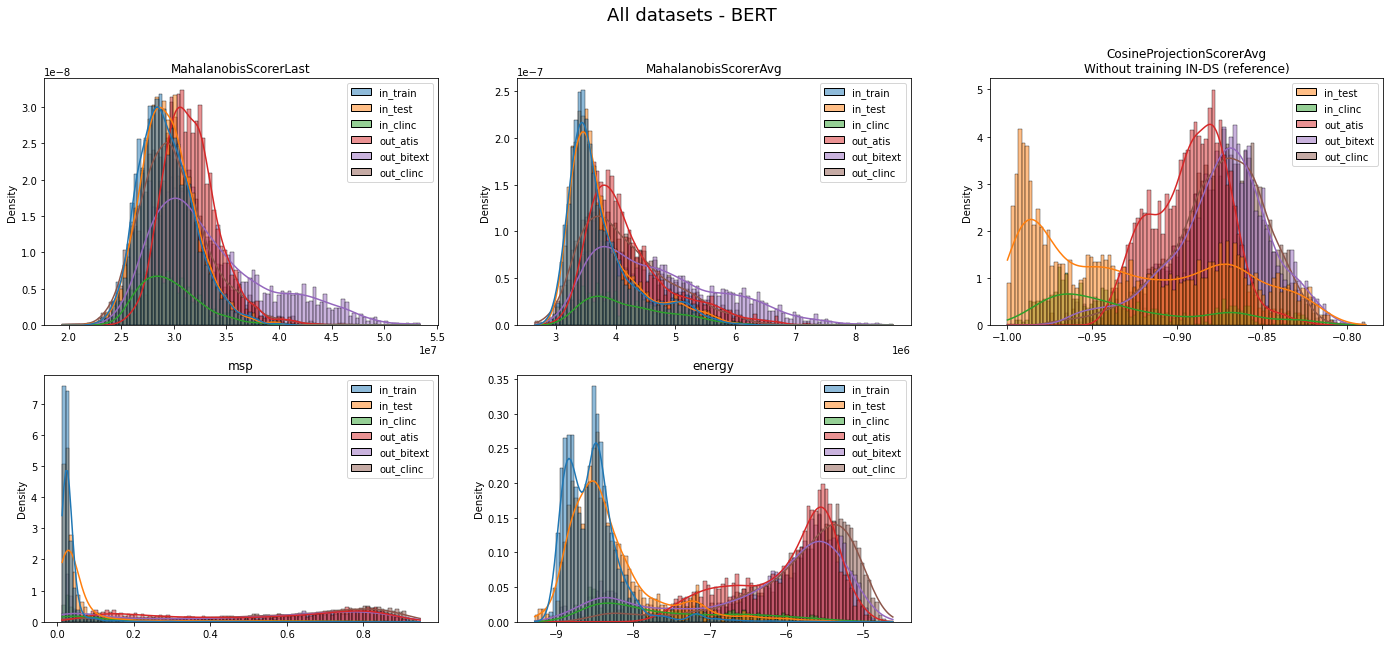

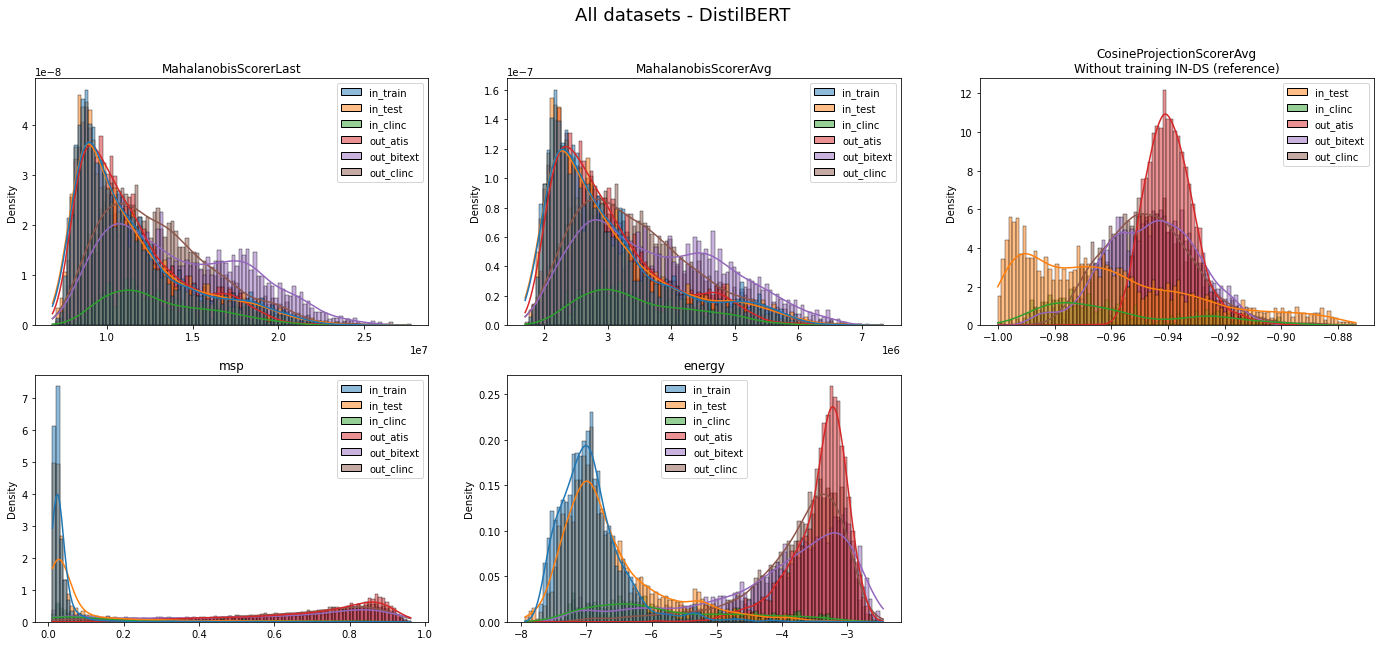

In [39]:
for model, scores in all_scores.items(): 

    fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(24, 10))
    fig.suptitle(f"All datasets - {model}", size=18)   

    for (scorer, records), ax in zip(scores.items(), axes.flatten()):
        plot_scorer_distrib(
            scorer, 
            records,
            ds_names=DS, 
            ax=ax, 
            density=True)

    axes[1, 2].set_axis_off()
    
    fig.show();  

#### `banking77`

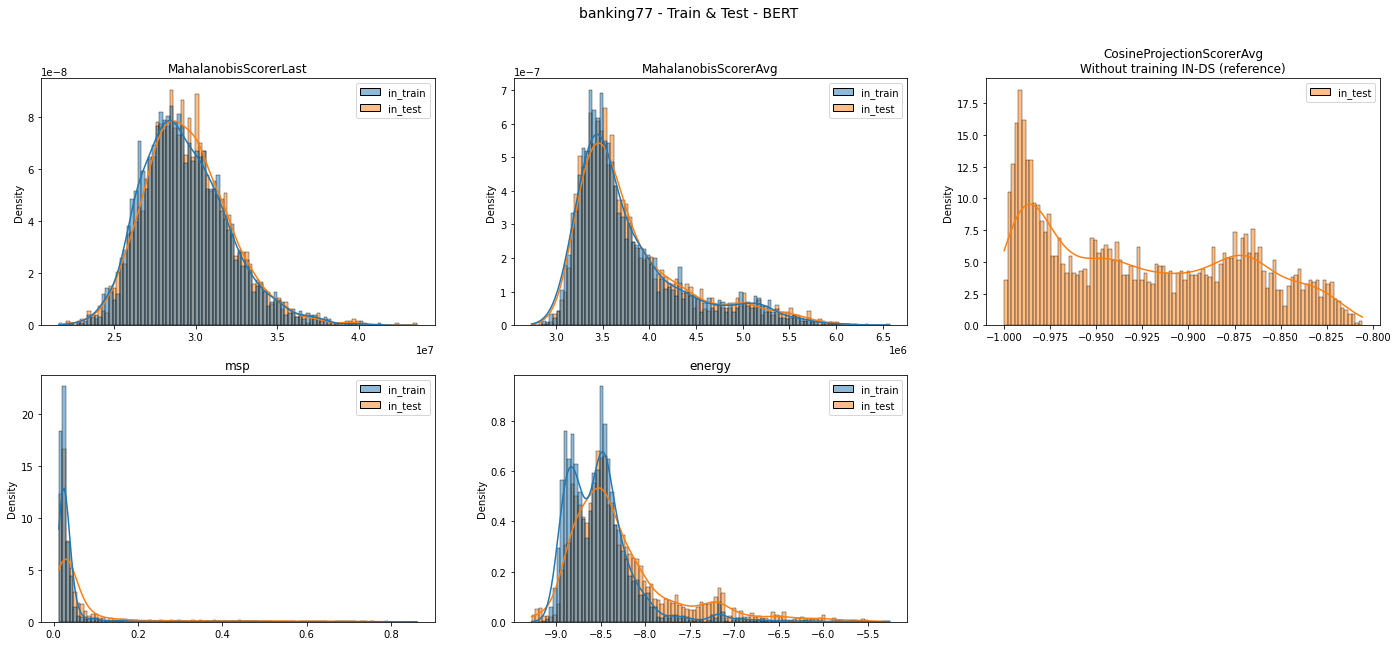

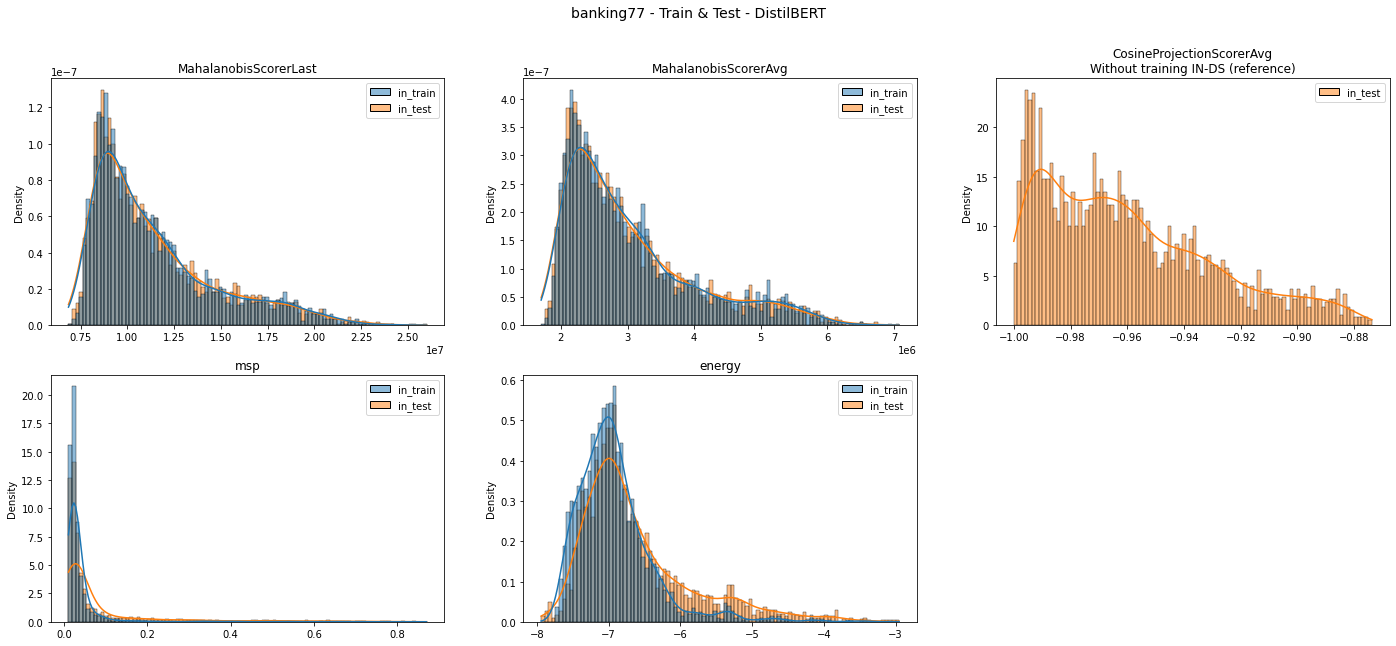

In [40]:
for model, scores in all_scores.items(): 

    fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(24, 10))
    fig.suptitle(f"banking77 - Train & Test - {model}", size=14)

    for (scorer, records), ax in zip(scores.items(), axes.flatten()):
        plot_scorer_distrib(
            scorer, 
            records,
            ds_names=["in_train", "in_test"], 
            ax=ax, 
            density=True)
        
    axes[1, 2].set_axis_off(); 

#### `banking77` & `ATIS`

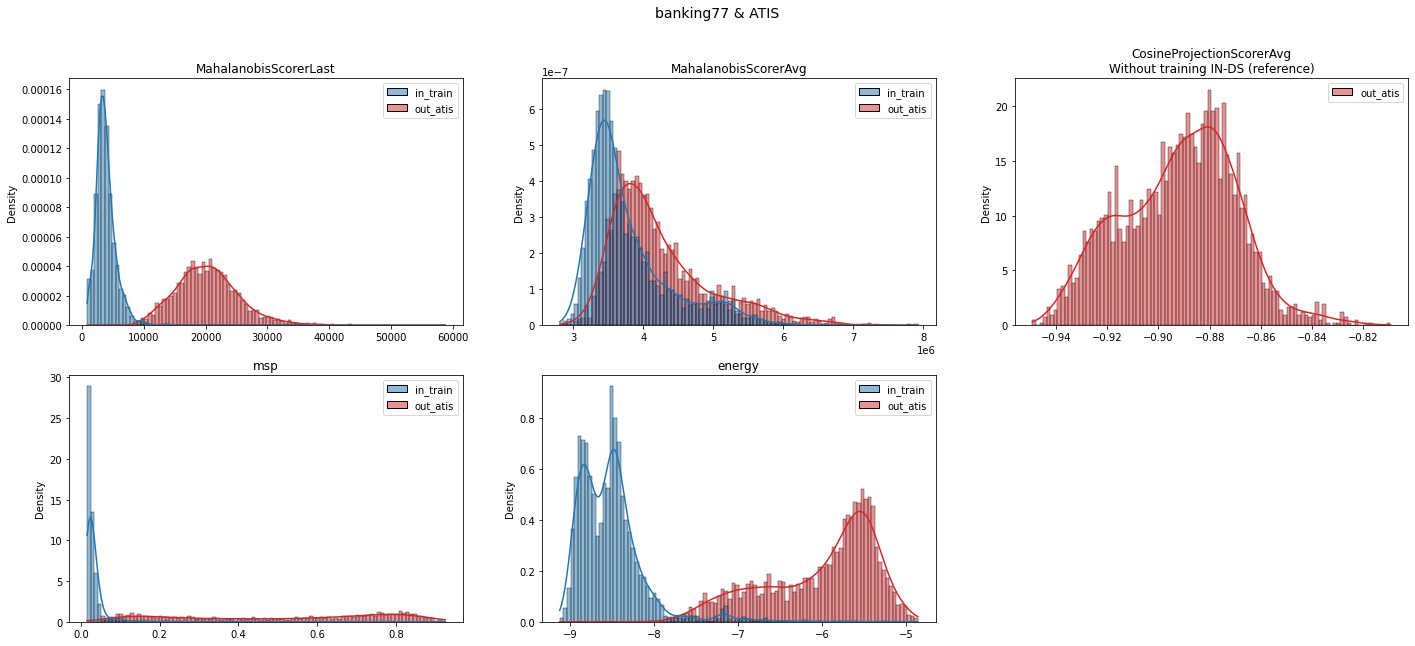

In [110]:
for model, scores in all_scores.items(): 
    
    fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(24, 10))
    fig.suptitle(f"banking77 & ATIS - {model}", size=14)

    for (scorer, records), ax in zip(scores.items(), axes.flatten()):
        plot_scorer_distrib(
            scorer, 
            records,
            ds_names=["in_train", "out_atis"], 
            ax=ax, 
            density=True)
        
    axes[1, 2].set_axis_off(); 

#### `banking77` & `Bitext`

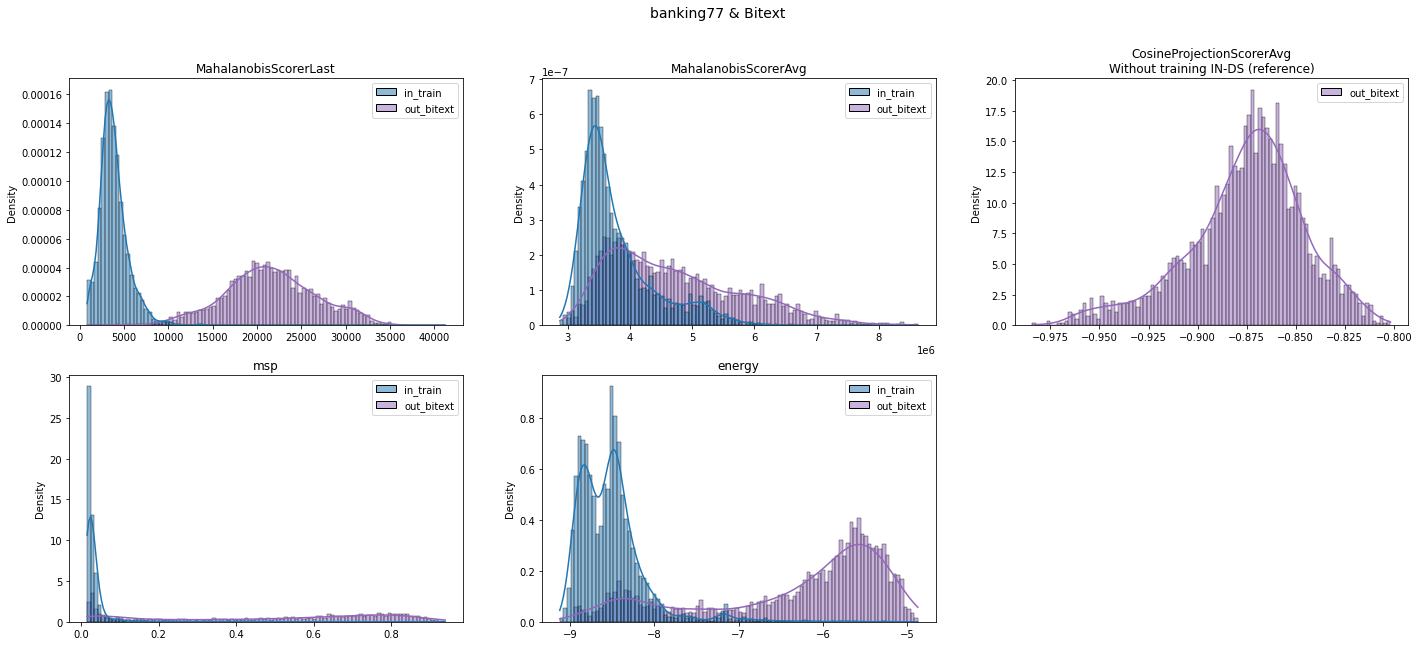

In [111]:
 for model, scores in all_scores.items():   
    
    fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(24, 10))
    fig.suptitle(f"banking77 & Bitext - {model}", size=14)

    for (scorer, records), ax in zip(scores.items(), axes.flatten()):
        plot_scorer_distrib(
            scorer, 
            records,
            ds_names=["in_train", "out_bitext"], 
            ax=ax, 
            density=True)
        
    axes[1, 2].set_axis_off(); 

#### `banking77` & `CLINC150`

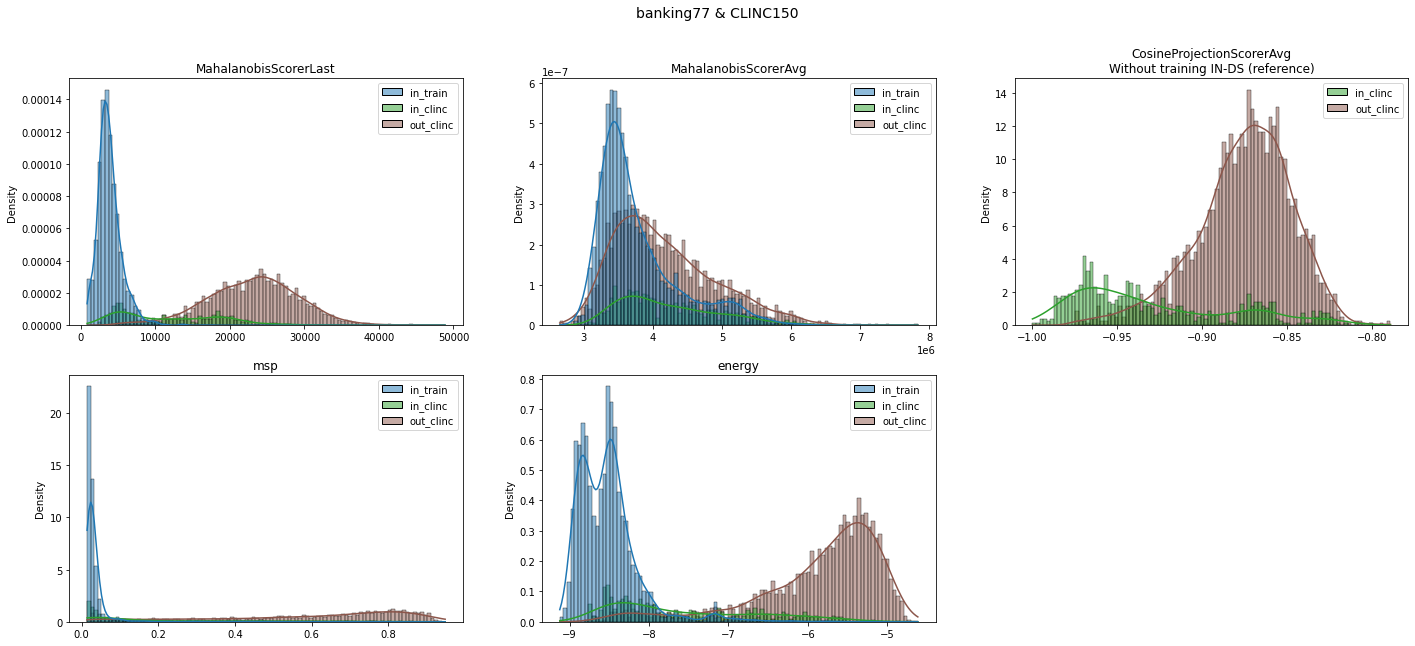

In [112]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(24, 10))
fig.suptitle("banking77 & CLINC150", size=14)

for (scorer, records), ax in zip(all_scores.items(), axes.flatten()):
    plot_scorer_distrib(
        scorer, 
        records,
        ds_names=["in_train", "in_clinc", "out_clinc"], 
        ax=ax, 
        density=True)
    
axes[1, 2].set_axis_off(); 

### Metrics

In [127]:
# get OOD labels 
    # 0 for IN-DS samples
    # 1 for OUT-DS samples

# IN-DS samples: b77, clinc150 (in)
num_in_samples = config_args_in["train_size"] + config_args_in["test_size"] + config_args_in_clinc["test_size"]
print(f"{num_in_samples} intents labeled as in-distribution.")

ood_labels_in = [config_args_in["ood_label"] for _ in range(num_in_samples)]

# OUT-DS samples: atis, bitext, clinc150 (out)
num_out_samples = config_args_out["test_size"] * 3
print(f"{num_out_samples} intents labeled as in-distribution.")

ood_labels_out = [config_args_out["ood_label"] for _ in range(num_out_samples)]

ood_labels = ood_labels_in + ood_labels_out

# get OOD scores for each scoring function
ood_scores = {
    scorer: list(
        chain(*[
          ds for ds in all_scores[scorer].values()
      ])
    )
    for scorer in SCORERS 
}

# compute (fpr, tpr) for different thresolds
roc = {
    scorer: roc_curve(ood_labels, ood_scores[scorer], pos_label=1)
    for scorer in SCORERS
}

auroc = {
    scorer: auc(fpr, tpr)
    for scorer, (fpr, tpr, _) in roc.items()
}

print(auroc)

# compute (precision, recall) for different thresolds
prc = {
    scorer: precision_recall_curve(ood_labels, ood_scores[scorer], pos_label=1)
    for scorer in SCORERS
}

aupr = {
    scorer: auc(recall, precision)
    for scorer, (precision, recall, _) in prc.items()
}

print(aupr)

6750 intents labeled as in-distribution.

9000 intents labeled as in-distribution.

{
    'MahalanobisScorerLast': 0.8955019423868312,
    'MahalanobisScorerAvg': 0.703250024691358,
    'CosineProjectionScorerAvg': 0.8588520987654322,
    'msp': 0.938112148148148,
    'energy': 0.9528565267489713
}

{
    'MahalanobisScorerLast': 0.8889323444155536,
    'MahalanobisScorerAvg': 0.750272639077201,
    'CosineProjectionScorerAvg': 0.8024653651336807,
    'msp': 0.9517875958606083,
    'energy': 0.9657924975080727
}

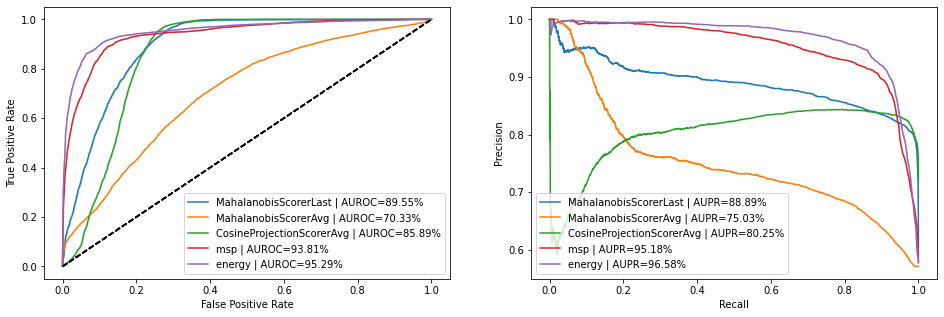

In [129]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 5))

for scorer, (fpr, tpr, _) in roc.items(): 
    label = f"{scorer} | AUROC={round(100*auroc[scorer], 2)}%"

    sns.lineplot(
        x=fpr, 
        y=tpr, 
        label=label, 
        color=COLORS_SCORERS[scorer], 
        ax=axes[0])
    
    sns.lineplot(x=[0, 1], y=[0, 1], linestyle="dashed", color="black", ax=axes[0]) 

axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")

for scorer, (precision, recall, _) in prc.items(): 
    label = f"{scorer} | AUPR={round(100*aupr[scorer], 2)}%"

    sns.lineplot(
        x=recall, 
        y=precision, 
        label=label, 
        color=COLORS_SCORERS[scorer], 
        ax=axes[1])

axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision");

**Note**: precision & recall

$$
\begin{aligned}
\text{Pr}  & = \mathbb{P}(Z=1 \mid s(\mathrm{x}) \leq \gamma) \\
\text{Re} & = \mathbb{P}(s(\mathrm{x}) \leq \gamma \mid Z=1)
\end{aligned}
$$

where $s(.)$ is the scoring function and $\gamma$ the thresold. 